# Geoinformática - Práctica 6
## Agrupamiento, Regionalización y Segmentación Geodemográfica
## Parte 1 - Introducción a la Regionalización

In [1]:
# Librerías a Utilizar
import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster

### Datos de Trabajo
En esta primera parte de la práctica, se utilizarán datos extraídos de la [Base de Datos oficial de AirBnb](http://insideairbnb.com/get-the-data.html); se trata de una compañía que provee alternativas de hospedaje diferentes de los hoteles a las personas que visitan un lugar determinado, así como de un ingreso adicional a aquellos con la posibilidad de rentar sus inmuebles. El [sitio web](https://www.airbnb.com/) de la compañía se actualiza de manera constante con el listado de todas las propiedades disponibles en un lugar dado para los usuarios puedan revisar y reservar según sus necesidades; asimismo, el servicio provee de un mecanismo de retroalimentación en el que ambas partes, tanto anfitriones como huéspedes, tienen la posibilidad de calificar su experiencia, lo cual permite que cada propiedad tenga no sólo una Calificación General de su aptitud como estancia, sino también puntuaciones relacionadas a la limpieza del inmueble, la facilidad de comunicación con el huésped, entre otras.

Los datos originales proporcionados por AirBnb se encuentran detallados a nivel propiedad para toda la Ciudad de México; sin embargo, dado que el número de inmuebles en esta base es demasiado alto, para propósitos de la práctica, los datos han sido agregados a nivel de AGEB. Asimismo, aunque los datos se encuentran disponibles para toda la ciudad, la gran mayoría de estas propiedades se encuentran concentradas en la Alcaldía Cuauhtémoc, donde se ubican los principales atractivos turísticos de la ciudad como el Centro Histórico, el Palacio de Bellas Artes o la Condesa; como tal, se trabajará únicamente con esta alcaldía y, dado que no todas las AGEB's de la alcaldía poseen un AirBnb, únicamente se trabajarán con las AGEB's de la Alcaldía Cuahtémoc que posean por lo menos un AirBnb en su interior, de modo que se le puedan asociar los promedios de calificaciones.

El objetivo de la práctica es crear una clasificación de las áreas (AGEB's) de la Alcaldía Cuauhtémoc, en la Ciudad de México, basándose en las calificaciones que los AirBnb en su interior han recibido. Esto permitirá crear una tipología para la geografía de AirBnb en la alcaldía y, hasta cierto punto, entender un poco mejor la distribución de las propiedades en la misma a través de lo que los propios AirBnb puedan decir del lugar en el que se encuentran. Por una parte, este ejercicio es una prueba idónea para demostrar el tipo de análisis que pueden realizarse gracias a la aparición de nuevas y grandes bases de datos en todas las áreas, algo que hace sólo algunos pocos años hubiera sido muy complicado de realizar por otros medios; por otra parte, es importante tomar en cuenta las restricciones que poseen este tipo de datos y, por ende, limitan la posibilidad de hacer interpretaciones completamente certeras hacia la población en general.

En primer lugar, y como se ha hecho hasta ahora, se establecerá una variable que contenga la ruta en la cual se encuentran almacenados los datos:

In [2]:
f = 'data/'

Después, puede importarse el `ShapeFile` a utilizar a lo largo de la práctica, como se ha hecho tradicionalmente a través de `geopandas`:

In [3]:
airbnb = gpd.read_file('data/agebs_airbnb.shp')  # Importar el ShapeFile
airbnb = airbnb.set_index('ageb')                # Establecer la Clave Geográfica del AGEB como Índice
airbnb.head()                                    # Observar el GeoDataFrame importado

,no_prop,calif,expec,limp,checkin,com,ubi,precio,geometry
ageb,,,,,,,,,
0901500010235,4.0,96.5000,10.00000,10.00000,10.00000,10.00000,10.00000,9.75000,"POLYGON ((484786.456 2151318.632, 484743.189 2..."
0901500010362,1.0,100.0000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484415.300 2150990.921, 484453.443 2..."
0901500010606,14.0,96.3571,9.92857,10.00000,10.00000,9.92857,9.71429,9.85714,"POLYGON ((483366.717 2150099.091, 483446.519 2..."
0901500011017,204.0,96.1569,9.83823,9.64706,9.86765,9.86765,9.92157,9.68627,"POLYGON ((483869.067 2147955.234, 483852.569 2..."
0901500010201,1.0,100.0000,9.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484252.797 2151134.264, 484264.757 2..."


In [7]:
airbnb.geometry

ageb
0901500010235    POLYGON ((484786.456 2151318.632, 484743.189 2...
0901500010362    POLYGON ((484415.300 2150990.921, 484453.443 2...
0901500010606    POLYGON ((483366.717 2150099.091, 483446.519 2...
0901500011017    POLYGON ((483869.067 2147955.234, 483852.569 2...
0901500010201    POLYGON ((484252.797 2151134.264, 484264.757 2...
                                       ...                        
0901500010254    POLYGON ((484973.235 2151050.328, 484920.104 2...
0901500010396    POLYGON ((485047.475 2151035.983, 485018.902 2...
0901500010216    POLYGON ((484382.201 2151423.820, 484462.475 2...
0901500010076    POLYGON ((484933.289 2151283.181, 484786.456 2...
090150001017A    POLYGON ((483630.681 2151563.805, 483615.164 2...
Name: geometry, Length: 153, dtype: geometry

A continuación se presenta el significado de cada una de las variables contenidas en el `GeoDataFrame`; es importante recordar que las calificaciones mostradas para cada AGEB **resultan del promedio de todas las propiedades contenidas en su interior**:
* `no_prop` - Número de Propiedades contenidas en el AGEB.
* `calif` - Calificación General de las Propiedades, en una escala del 0 al 100.
* `expec` - Calificación de Expectativa, es decir, qué tanto se asemeja la experiencia real con lo prometido.
* `limp` - Calificación de Limpieza general de la propiedad.
* `checkin` - Calificación de la facilidad con la que fue posible realizar el Check-In a la propiedad.
* `com` - Calificación de facilidad de Comunicación entre el huésped y el anfitrión
* `ubi` - Calificación de Ubicación de la propiedad con respecto a la accesibilidad a otros lugares de la ciudad.
* `precio` - Calificación del Precio, es decir, el equilibrio entre lo pagado y lo recibido.

Antes de comenzar a explorar los datos más a fondo, resulta de utilidad realizar un paso más. Puede observarse que no todas las variables contenidas en la tabla resultarán de utilidad para el ejercicio, sino únicamente las asociadas a las calificaciones; como tal, para facilitar el trabajo a futuro, se almacenará el nombre de cada una de estas dentro de una *Lista* (*Array*):

In [8]:
calificaciones = ['calif', 'expec', 'limp', 'checkin', 'com', 'ubi', 'precio']

___
### Conociendo los Datos
La mejor forma de comenzar a estudiar la geografía de las Calificaciones de AirBnb es graficandolas a todas ellas dentro de un mapa particular para cada una, lo cual nos dará una perspectiva univariada de cada una de las variables de interés.

Debido a que existen muchas columnas de las cuales generar un mapa, puede utilizarse un Bucle (*Loop*) del tipo `for` que genere cada uno de estos mapas, y los coloque dentro de una de las unidades de la figura principal:

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:236: UserWarning: Warning: Not eno

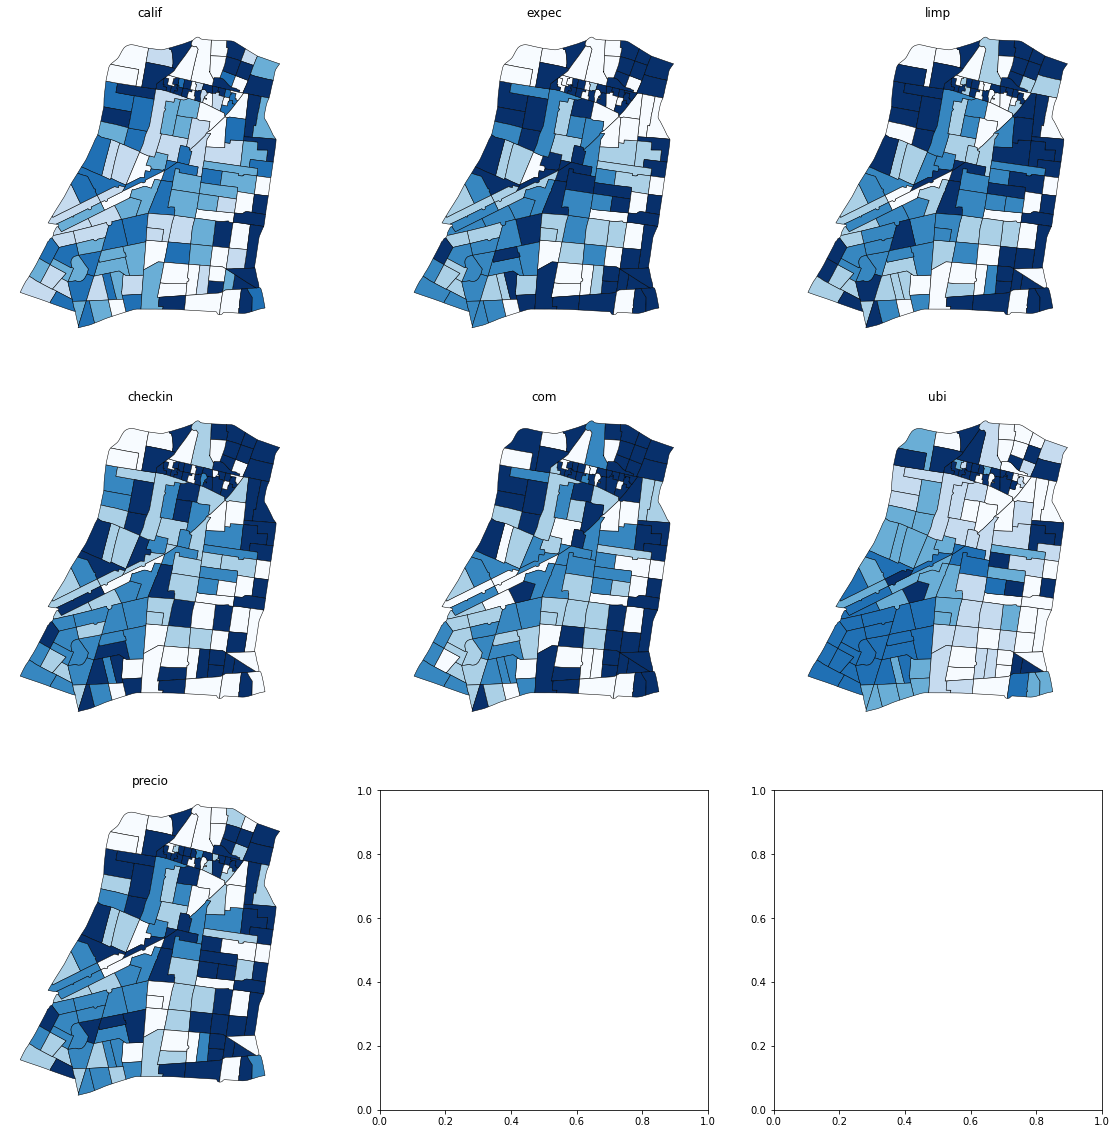

In [9]:
# Generación de figura con tres filas y tres columnas
fig, ejes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

# Hacer los accesibles a través de un solo índice con la función '.flatten()'
ejes = ejes.flatten()

# Comenzar el bucle utilizando todas las variables de interés
for i, var in enumerate(calificaciones):
    # Seleccionar el eje en el que se colocará el mapa
    eje = ejes[i]
    # Generar el mapa
    airbnb.plot(column=var, ax=eje, scheme='Quantiles', linewidth=0.5, edgecolor = 'black', cmap='Blues')
    # Remover los ejes del mapa
    eje.set_axis_off()
    # Colocar como título el nombre de la variable graficada
    eje.set_title(var)
    
plt.show()

Antes de realizar cualquier interpretación de los mapas, resulta pertinente estudiar a detalle el código que permitió generar los mapas anteriores:
1. Primero, en la Línea 2, se determina el número de filas y columnas de la cuadrícula en la cual se acomodarán los mapas, utilizando la función `.subplots()` de la librería `matplotlib`, así como sus argumentos `nrows` y `ncols` respectivamente.
2. Después, en la Línea 5, se utiliza la función `.flatten()` para que cada uno de los espacios de la cuadrícula puedan ser llamados de forma individual. Puede pensarse como una forma de enumerar los espacios de la cuadrícula; como tal, si se llama al elemento `ejes[0]` (recordando que *Python* comienza a enumerar desde 0), se estará trabajando con el primer cuadro de la primera fila; el elemento `ejes[1]` corresponderá al segundo de la primera fila; `ejes[2]` al tercero de la primera fila; `ejes[3]` al primero de la segunda fila, y así consecutivamente.
3. En la Línea 8 se genera el bucle de tipo `for` utilizando la lista de `calificaciones` que se generó anteriormente; sin embargo, se está aplicando el método `enumerate()` sobre la lista. Esto se debe a que la función `enumerate()`, como indica su nombre, enumera a los elementos de la lista; como tal, en la lista `calificaciones`, al elemento `calif` se le asigna el número 0, a `expec` el número 1, y así con el resto. Lo anterior permite que las variables generadas por el bucle, `var` e `i`, correspondan a la variable con la que se generará el mapa y su ennumeración correspondiente, respectivamente.
4. Dentro del bucle, primero se establece con cual de los ejes (o, elemento de la cuadrícula) se trabajará para generar el mapa (Línea 10); después, se genera el mapa a través de la función `.plot()` (Línea 12); posteriormente, se remueven los ejes del mapa generado con `.set_axis_off()` (Línea 14) y, por último, se le coloca como título al mapa el nombre de la variable con la que se ha trabajado.
5. Para finalizar, simplemente se muestra el resultado (Línea 18).

Gracias a los mapas generados, **es posible observar que existe una diferencia sustancial en cómo se distribuyen las calificaciones de cada uno de los aspectos de un AirBnb en el espacio**. Mientras que la Calificación General (`calif`), la de Comunicación con el Anfitrión (`com`) y la Ubicación (`ubi`) tienden a ser altas en muy pocas AGEB's, principalmente las concentradas en los límites de la alcaldía, otras calificaciones como las de Precio (`prec`) o Expectativa (`expec`) también tienden a concentrarse en el centro de la misma, donde se encuentra el Centro Histórico.

Aunque se está trabajando con un número relativamente pequeño de variables, **resulta complicado a primera instancia determinar cómo funcionan en conjunto y de qué forma se relacionan como un todo con la naturaleza de cada una de las AGEB's estudiadas**. Como tal, también resulta de utilidad estudiar la Correlación entre cada una de las variables (como influye una en la otra) y, para esto, la librería `seaborn` ofrece la función [`.pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html), que permite estudiar esta correlación entre un grupo de variables de forma gráfica:

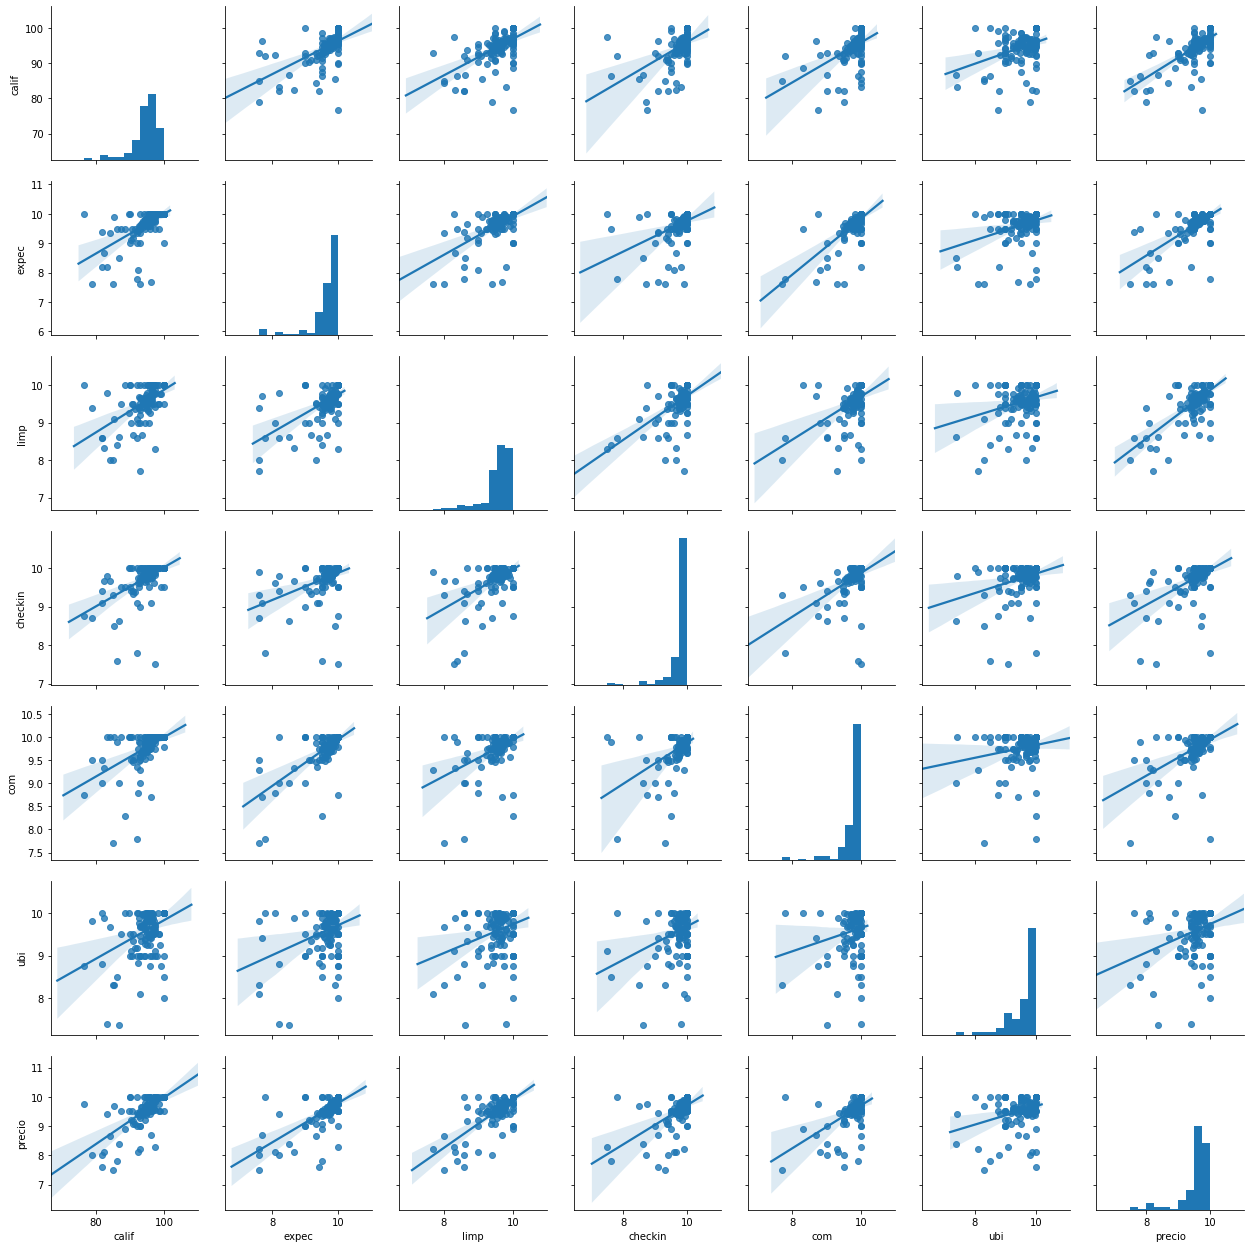

In [6]:
_ = sns.pairplot(airbnb[calificaciones], kind='reg', diag_kind='hist')

El conjunto de gráficas anterior permite responder preguntas de naturaleza univariada o bivariada, como por ejemplo:
* *¿Cuál es el rango de calificaciones para el parámetro de Limpieza, y cuál es la calificación más común?* - En este caso, en la intersección del parámetro `limp` de ambos ejes se encuentra un Histograma que muestra que todas las calificaciones de este parámetro se encuentran en un rango de entre 8 y 10, siendo las más comunes las que se encuentran en un rango de entre 9.6 y 9.8.
* *¿Cuál es la relación entre la Calificación General y la de Ubicación?* - Si se observa la intersección entre `calif` y `ubi`, se observará que es de tipo *Positiva*, es decir, mientras mejor sea una calificación, mayor será la otra.
* *¿La Calificación General guarda una mayor correlación con la de Ubicación o la de Limpieza?* - Debido a que la recta presente en en la intersección de `calif` con `limp` presenta una mayor inclinación que la existente en la intersección con `ubi`, se concluye que la calificación de Limpieza tiene una mayor correlación.

Como tal, puede observarse que una gran cantidad de preguntas pueden responderse estudiando la correlación entre pares de variables; sin embargo, esto no puede resultar suficiente cuando se hacen preguntas sofisticadas y de naturaleza multivariada. La figura anterior no permite responder con certeza preguntas como:
* ¿Cuáles son las principales características de la zona suroeste de la Alcaldía Cuauhtémoc?
* ¿Qué otras AGEB's son similares a las que contienen el Centro Histórico?
* ¿Los AirBnb encontrados al oriente de la alcaldía son similares a los presentes en el occidente?

Para responder este tipo de preguntas, que involucran una gran cantidad de variables al mismo tiempo, se requiere de un método verdaderamente multivariado, como lo es el *Agrupamiento Estadístico*.

#### Ejercicio Opcional
Revisa la [documentación oficial](https://seaborn.pydata.org/generated/seaborn.pairplot.html) de la función `.pairplot()` y experimenta con los parámetros de la misma; por ejemplo, cambia los Histogramas generados en la figura de arriba por Estimaciones de Densidad de Kernel (KDE).
___
### Clasificación Geodemográfica - Método *K-Means*
Un análisis geodemográfico invloucra la clasificación de las áreas que forman un mapa geográfico en grupos o categorías de observaciones que se asemejan entre sí, pero resultan diferentes a las presentes en otras categorías. La clasificación se lleva a cabo utilizando un algoritmo de *Agrupamiento Estadístico* (*Clustering*) que toma como referencia un conjunto de atributos y regresa el grupo (o la *etiqueta*) a la que pertenece cada una de las observaciones; dependiendo del algoritmo particular utilizado, parámetros adicionales deben de ser establecidos por el usuario, los cuales pueden variar desde elementos básicos como el número de agrupaciones deseado, hasta detalles más avanzados como ancho de banda, radio, entre otroas.

Para la Clasificación Geodemográfica de la Alcaldía Cuahtémoc utilizando las calificaciones de AirBnb, se utilizará uno de los algoritmos de *Agrupamiento Estadístico* más populares: *K-Means* (o *K-Medias*, al traducirlo al español). Esta técnica ´unicamente requiere como entrada los atributos de las observaciones a tomar como referencia y el número de grupos en los que se desea clasificar a las observaciones; en este caso, se iniciará generando únicamente cinco categorías, para entender con facilidad el resultado obtenido.

Aunque el algoritmo asociado al Método *K-Means* no es para nada trivial, ejecutarlo en *Python* es bastante sencillo gracias a la librería `scikit-learn`, pues únicamente se necesitan dos líneas de código. Primero se necesita ejecutar el método `.KMeans()`, perteneciente al submódulo `cluster` de la librería `scikit-learn`, para establecer los parámetros del algoritmo; en este paso, aún no es necesario introducir las variables, sino únicamente determinar el número de *Clusters* en los cuales se desea agrupar a los datos:

In [7]:
kmeans5 = cluster.KMeans(n_clusters=5)

El resultado del método `.KMeans()` fue almacenado dentro de una variable llamada `kmeans5`; aunque únicamente se colocó de forma explícita el argumento `n_clusters` para determinar el número deseado de grupos, el método posee muchos otros que establece por defecto, y que pueden ser revisados si se analiza a la variable generada:

In [8]:
kmeans5

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Para verdaderamente ejecutar el algoritmo, es necesario ejecutar el método `.fit()` sobre la variable antes creada, esta vez estableciendo cuáles son las variables que se utilizarán como referencia para generar los grupos:

In [9]:
# Asegurar que siempre se obtengan los mismos resultados; cambiar el número cambiará los resultados
np.random.seed(1234)

# Ejecutar el algoritmo con las variables establecidas
k5cls = kmeans5.fit(airbnb[calificaciones])

El objeto contenido dentro de la variable `k5cls` contiene una gran cantidad de componentes que pueden ser utilizados para el análisis; por ahora, únicamente se utilizará el llamado `labels_`, que representa las diferentes categorías en las cuales han sido agrupados los datos; es importante recordar que Python comienza su numeración desde el cero, por lo que las etiquetas se encuentran marcadas del 0 al 4 para representar cinco grupos:

In [10]:
k5cls.labels_

array([3, 0, 3, 3, 0, 0, 0, 3, 0, 0, 3, 1, 0, 0, 3, 2, 3, 2, 3, 3, 2, 3,
       3, 3, 0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 2, 1, 2, 0, 2, 0, 0, 1, 3, 3, 0, 0, 3, 2, 2, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, 3, 3, 2, 3,
       3, 3, 3, 3, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       0, 4, 4, 3, 3, 3, 3, 3, 3, 1, 2, 1, 2, 0, 0, 0, 2, 1, 4, 4, 2],
      dtype=int32)

Cada número representa una categoría diferente, lo que significa que si a dos observaciones se les ha asignado el mismo número, entonces pertenecerán al mismo grupo. Dado que el orden en que se encuentran estas etiquetas es exactamente el mismo que el orden de los atributos utilizados para su generación, es posible colocar éstas como una nueva columna en el `GeoDataFrame` original:

In [11]:
airbnb['k5cls'] = k5cls.labels_
airbnb.head()

,no_prop,calif,expec,limp,checkin,com,ubi,precio,geometry,k5cls
ageb,,,,,,,,,,
0901500010235,4.0,96.5000,10.00000,10.00000,10.00000,10.00000,10.00000,9.75000,"POLYGON ((484786.4564242049 2151318.632194062,...",3
0901500010362,1.0,100.0000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484415.3002532361 2150990.921335925,...",0
0901500010606,14.0,96.3571,9.92857,10.00000,10.00000,9.92857,9.71429,9.85714,"POLYGON ((483366.716567839 2150099.090658844, ...",3
0901500011017,204.0,96.1569,9.83823,9.64706,9.86765,9.86765,9.92157,9.68627,"POLYGON ((483869.0666524998 2147955.234262425,...",3
0901500010201,1.0,100.0000,9.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484252.7970705956 2151134.263629142,...",0


___
### Visualización en Mapa
Para entender con más detalle el resultado obtenido, resulta útil visualizar las categorías generadas en un mapa. Para esto, se generará un Mapa de Coropletas en el que cada categoría se asociará automáticamente a un color diferente, lo cual se logra gracias al argumento `categorical` de la función `.plot()`:

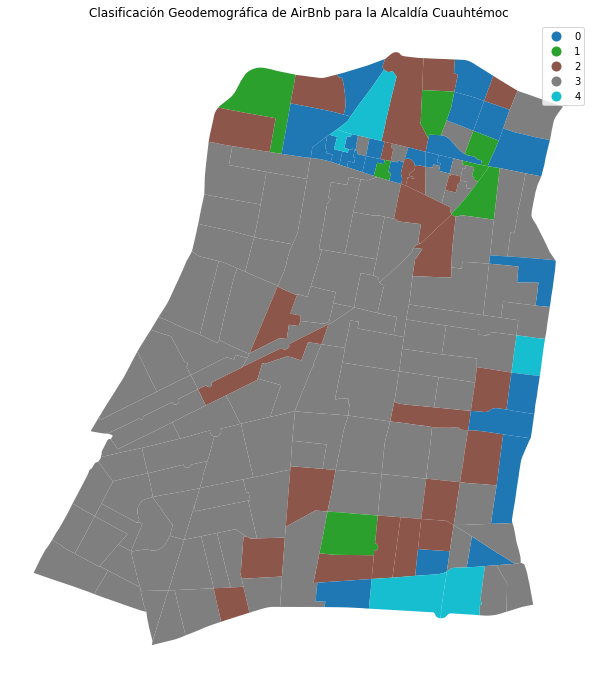

In [12]:
# Crear la figura y sus ejes
fig, ejes = plt.subplots(1, figsize=(12, 12))

# Generar un Mapa de Coropletas Categórico
airbnb.plot(column='k5cls', categorical=True, legend=True, edgecolor='', ax=ejes)

# Remover los ejes del mapa
ejes.set_axis_off()

# Asignar un título
plt.title('Clasificación Geodemográfica de AirBnb para la Alcaldía Cuauhtémoc')

# Mostrar el resultado
plt.show()

El mapa anterior representa la Distribución Geográfica de las cinco categorías creadas por el Algoritmo *K-Means*. A través de éste, es posible observar cierto patrón espacial en los resultados; por una parte, la Categorías 3 (Gris) es la que abarca la gran mayoría de la alcaldía, comprendiendo casi todas las AGEB's en el centro y suroeste de la misma; la Categoría 0 (Azul Oscuro) es la siguiente en términos de tamaño, distribuyéndose principalmente en los límites norte y este; las Categorías 1, 2 y 4 son las del menor número de elementos, distribuyéndose de forma algo heterogénea a lo largo de toda la alcaldía..
___
### Analizando las Categorías
Resulta útil no sólo entender cómo es que se han distribuído las categorías en el espacio, sino también entender el porqué los elementos se han agrupado de la forma en que lo hicieron, razón por la cual se recurre a la Estadística. Como primer paso, es importante saber cuántas observaciones fueron asignadas a cada categoría; para ello, se utilizará la función `.groupby()` de la librería `pandas`, [estudiada en prácticas anteriores](../01_transformacion/01_transformacion.html), utilizando también el método `.size()` que obtiene el número de elementos en un subgrupo:

In [13]:
k5_cuentas = airbnb.groupby('k5cls').size()
k5_cuentas

k5cls
0    25
1     7
2    24
3    92
4     5
dtype: int64

El operador `.groupby()` toma un `DataFrame` y lo agrupa utilizando los valores de una columna dada (`k5cls`), lo cual permite aplicar sobre éste alguna operación dada, en este caso `.size()`; en otras palabras, lo que se realiza es agrupar en función de las categorías creadas, y contar cuántos elementos posee cada una. Para entender esto visualmente, puede realizarse una Gráfica de Barras:

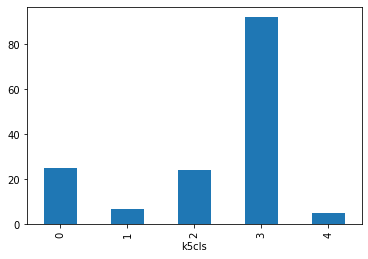

In [14]:
_ = k5_cuentas.plot.bar()

Como se observó en el mapa, cada una de las categorías posee un número diferente de elementos; la Categoría 3 rebasa por mucho las 80 observaciones, mientras que las Categorías 1 y 4 no logran superar las 20.

Para continuar describiendo las características de cada categoría, pueden estudiarse los valores de los atributos utilizados para crearlas. Recordando que se utilizaron las calificaciones de los AirBnb contenidos en cada AGEB para generar las categorías, podría estudiarse cuál terminó siendo el valor promedio de cada una de éstas dentro de las categorías; para esto, nuevamente se puede recurrir al método `.groupby()`, pero esta vez combinándolo con la función `.mean()`:

In [15]:
# Calcular la media de todas las calificaciones para cada Categoría
k5_promedios = airbnb.groupby('k5cls')[calificaciones].mean()

# Transponer la tabla, únicamente por cuestiones de visualización
k5_promedios.T

k5cls,0,1,2,3,4
calif,99.640,85.487614,91.774046,95.546245,80.416660
expec,9.940,8.933333,9.251748,9.759300,8.773334
limp,9.920,8.775000,9.357794,9.627852,8.986666
checkin,9.960,8.998810,9.573408,9.832197,9.123334
com,9.992,9.514286,9.497838,9.838345,9.216666
ubi,9.660,8.434524,9.355548,9.724755,9.447778
precio,9.930,8.705953,9.275514,9.649814,8.292222


Analizando únicamente la Calificación General (`calif`), podría decirse que las AGEB's con los AirBnb mejor claificados se concentran en la Categoría 0, mientras que los peor calificados son los de la Categoría 4.

Si se desea estudiar con mucho más detalle cada una de las categorías, desde el punto de vista estadístico, podría combinarse la función `.groupby()` con `.describe()`, lo cual arrojará un mayor número de cálculos:

In [16]:
# Obtener un Resumen Estadístico de cada una de las Categorías
k5_estad = airbnb.groupby('k5cls')[calificaciones].describe()
# Observar el resultado
k5_estad

calif                                                                   \
      count       mean       std      min         25%        50%         75%   
k5cls                                                                          
0      25.0  99.640000  0.673455  98.0000  100.000000  100.00000  100.000000   
1       7.0  85.487614  1.472272  83.2000   84.666650   85.40000   86.490000   
2      24.0  91.774046  1.320847  88.7000   90.749975   92.24545   92.890225   
3      92.0  95.546245  0.956859  93.6667   94.946850   95.48035   96.179825   
4       5.0  80.416660  2.456561  76.7500   79.000000   82.00000   82.000000   

                expec            ...       ubi           precio            \
            max count      mean  ...       75%       max  count      mean   
k5cls                            ...                                        
0      100.0000  25.0  9.940000  ...  10.00000  10.00000   25.0  9.930000   
1       87.5000   7.0  8.933333  ...   9.00000   9.66667    7.0  8.705953   
2       93.3333  24.0  9.251748  ...   9.70701  10.00000   24.0  9.275514   
3       97.4000  92.0  9.759300  ...   9.95560  10.00000   92.0  9.649814   
4       82.3333   5.0  8.773334  ...   9.88889  10.00000    5.0  8.292222   

                                                              
            std  min        25%        50%        75%    max  
k5cls                                                         
0      0.169558  9.5  10.000000  10.000000  10.000000  10.00  
1      0.864724  7.5   8.087500   8.666670   9.450000   9.70  
2      0.466774  8.1   9.046875   9.379565   9.500000  10.00  
3      0.245688  8.3   9.563627   9.636565   9.753678  10.00  
4      0.837836  7.6   8.000000   8.000000   8.111110   9.75  

[5 rows x 56 columns]

Con esto, es posible concluir la sección relacionada con Segmentación Geodemográfica. Puede resaltarse que la escencia del algoritmo ejecutado, y de todos los que corresponden a esta categoría, tiene una base completamente estadistica, esto es, el *dónde* se encuentran las observaciones no tiene relevacia alguna para el algoritmo al momento de clasificar. En algunos casos, lo anterior puede resultar idóneo, sobretodo si el objetivo de la investigación se centra en conocer si los datos tienen algún tipo de Distribución Espacial por sí mismos; sin embargo, si de antemano se sabe que esta distribución existe, y el objetivo de la investigación lo amerita, entonces se necesita tomar en cuenta la componente espacial para el cálculo.

Para esto, se recurre a las técnicas de *Regionalización*.
___
## Algoritmos de Regionalización
Se le conoce como *Regionalización* al subconjunto de técnicas de agrupamiento que consideran a la componente espacial dentro de la clasificación; en otras palabras, el resultado de regionalizar involucra áreas que son contínuas en el espacio. Lo anterior significa que estas técnicas agregan áreas en un conjunto de menor númer de unidades espaciales, llamadas regiones; lo anterior implica que las áreas se encuentran anidadas dentro de las regiones.

Ejemplos de lo anterior son los estados (áreas) que se encuentran contenidos dentro de un país (región) o, en el caso de México, los municipio (áreas) contenidos dentro de un estado (región); la diferencia principal entre los ejemplos anteriores y el resultado de un algoritmo de *Regionalización* es que, mientras las anteriores fueron generadas meramente a partir de principios administrativos, políticos o sociales, el algoritmo sigue principios estadísticos y, al igual que su variante no espacial, trata de conjuntar observaciones cuyos atributos sean lo más matemáticamente similares, siguendo también ahora las limitantes establecidas por la componente espacial.

Al igual que en el caso no espacial, existen una gran cantidad de algoritmos para generar una *Regionalización*, todos ellos variando en la forma en la que se mide la semejanza o diferencia de los atributos, el proceso de la regionalizacíon, entre otros. Aún así, todos ellos comparten algunos aspectos en común; en particular, todos ellos toman como referencia un conjunto de atributos y la representación del espacio (a través de Matrices de Pesos Espaciales), así como, en algunos casos, el número de regiones que se desean generar.

Para ilustrar estos conceptos, se aplicará un Algoritmo de Regionalización sobre los datos de AirBnb utilizados hasta ahora. En este caso, el objetivo será dividir la alcaldía en Colonias, basándose en las calificaciones de las propiedades de AirBnb en lugar de las razones administrativas detrás de las Colonias que verdaderamente existen en ésta; como tal, se generarán regiones formadas de AGEB's con similitudes en sus calificaciones de AirBnb.

Para esto, se utilizará una nueva librería de *Python* llamada `clusterpy`. Si se revisan los archivos que forman la unidad, se encontrará que dentro de la misma carpeta de trabajo existe una carpeta con este nombre; lo anterior se debe a que `clusterpy` no es una librería ampliamente distribuida, como lo son `numpy` o `pandas`, por lo que no será encontrada a través del manejador de liberías *Conda* o de forma sencilla buscando en internet. `clusterpy` se trata de una librería local y, al igual que el resto de las librerías trabajadas hasta ahora, puede ser importada sencillamente a través de `import`:

In [17]:
import clusterpy

ClusterPy: Library of spatially constrained clustering algorithms
Some functions are not available, reason: No module named 'Polygon'
Some functions are not available, reason: No module named 'Polygon'


Es importante resaltar que, en Python, no sólamente pueden utilizarse librerías ampliamente distribuidas, como las manejadas hasta ahora, sino también aquellas que desarrollen autores y grupos de trabajo de forma local, siempre y cuando se coloquen en el lugar correcto para trabajarlas.

Para utilizar los Algoritmos de Regionalización contenidos en `clusterpy`, primero es necesario importar el `ShapeFile` original en lo que la librería llama un objeto de tipo `Layer`; esto es algo exclusivo de `clusterpy` pues, a diferencia de otras librerías, no puede utilizar la importación realizada por `GeoPandas`, y necesita generar una propia a través de su función `.importArcData()`:

In [18]:
layer = clusterpy.importArcData(f + 'agebs_airbnb')

Loading data/agebs_airbnb.dbf
Loading data/agebs_airbnb.shp
Done


Dentro de la variable `layer` se encuentra contenida la información que `clusterpy` necesita para trabajar; como tal, es posible llamar la función `.cluster()` para ejecutar un Algoritmo de Regionalización. Como se mencionó anteriormente, existen una gran cantidad de ellos; es posible visualizar todos los que la librería `clusterpy` contiene utilizando el siguiente comando:

In [ ]:
clusterpy.CPhelp('Layer.cluster')

En este caso, se utilizará el algotimo *Automated Zoning Procedure* (AZP) propuesto por S. Openshaw y L. Rao en 1995 ([Artículo Original](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.461.8982&rep=rep1&type=pdf)), el cual toma un conjunto de atributos, una Matriz de Pesos Espaciales y el número de regiones que se desea generar; para términos de comparación, se le solicitará al algoritmo que genere 33 regiones, que es el mismo número de colonias que puede encontrarse dentro de la Alcaldía Cuauhtémoc.

Puede notarse que, aunque se mencionó que el Algoritmo *AZP* requiere de una matriz de pesos espaciales, hasta el momento no se han utilizado [los métodos estudiados anteriormente](../05_autocorrelacion/05_autocorrelacion.html); esto se debe a que `clusterpy` genera su propia matriz, por lo que no es necesario volver a calcularla.

Como tal, el Algoritmo de Regionalización *AZP* se ejecuta a través de la función `.cluster()` de la siguiente forma:

In [20]:
layer.cluster('azp', calificaciones, 33, wType='queen')

Getting variables
Variables successfully extracted
Running original AZP algorithm (Openshaw and Rao, 1995)
Number of areas:  153
Number of regions:  33
Constructing regions
initial Solution:  [32, 12, 4, 19, 12, 2, 12, 2, 12, 2, 3, 23, 2, 2, 2, 2, 2, 24, 28, 2, 29, 29, 27, 29, 13, 29, 27, 15, 2, 2, 10, 10, 10, 10, 4, 10, 10, 17, 30, 22, 10, 20, 4, 19, 4, 4, 10, 10, 2, 3, 21, 12, 12, 3, 2, 12, 9, 25, 25, 12, 10, 10, 28, 28, 10, 25, 15, 31, 10, 10, 10, 10, 15, 15, 31, 10, 10, 10, 10, 17, 15, 27, 10, 15, 27, 19, 31, 10, 10, 10, 17, 13, 27, 27, 27, 13, 27, 27, 19, 10, 13, 27, 29, 29, 19, 10, 29, 10, 6, 10, 19, 19, 29, 29, 14, 30, 10, 6, 10, 29, 29, 29, 29, 19, 0, 29, 29, 19, 0, 19, 0, 0, 29, 16, 16, 13, 13, 10, 10, 13, 8, 1, 28, 3, 18, 2, 12, 12, 26, 26, 7, 5, 11]
initial O.F:  452.5311454924053
Performing local search
FINAL SOLUTION:  [32, 12, 15, 19, 12, 2, 12, 2, 12, 25, 3, 23, 2, 2, 2, 2, 2, 24, 28, 2, 29, 29, 27, 29, 13, 29, 27, 15, 2, 25, 10, 10, 10, 10, 4, 10, 10, 20, 30, 22, 10, 20

Cabe destacar la forma en la que fueron introducidos los argumentos dentro de la función `.cluster()`; primero, se especificó el tipo de algoritmo a ejecutar (`azp`); después, se introdujeron los atributos a tomar en cuenta para la regionalización, siendo la lista de atributos guardada en la variable `calificaciones`; posteriormente, el número de regiones deseadas (`33`), para terminar con el tipo de Matriz de Pesos Espaciales a utilizar en el análisis (`queen` para una Matriz de Contigüidad de Reina, y `rook` para una de Torre).

En este momento, la variable `layer` contiene una gran cantidad de información que puede ser analizada; sin embargo, al igual que como se hizo con el método *K-Means*, por el momento únicamente se desea saber a qué categoría pertenece cada una de las observaciones. Para esto, se puede revisar el atributo `region2areas` del objeto de tipo `Layer`, el cual arroja en forma de lista las etiquetas buscadas; como la lista se encuentra ordenada, es posible colocarla directamente como una nueva columna en el `GeoDataFrame` original:

In [21]:
airbnb['azpcls'] = layer.region2areas
airbnb.head()

,no_prop,calif,expec,limp,checkin,com,ubi,precio,geometry,k5cls,azpcls
ageb,,,,,,,,,,,
0901500010235,4.0,96.5000,10.00000,10.00000,10.00000,10.00000,10.00000,9.75000,"POLYGON ((484786.4564242049 2151318.632194062,...",3,32
0901500010362,1.0,100.0000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484415.3002532361 2150990.921335925,...",0,12
0901500010606,14.0,96.3571,9.92857,10.00000,10.00000,9.92857,9.71429,9.85714,"POLYGON ((483366.716567839 2150099.090658844, ...",3,15
0901500011017,204.0,96.1569,9.83823,9.64706,9.86765,9.86765,9.92157,9.68627,"POLYGON ((483869.0666524998 2147955.234262425,...",3,19
0901500010201,1.0,100.0000,9.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484252.7970705956 2151134.263629142,...",0,12


___
### Visualización en Mapa y Análisis Estadístico
Como tal, la nueva columna `azpcls` posee exactamente las mismas características que `k5cls`, utilizada anteriormente, pues contiene una variable categórica que puede ser colocada en un Mapa de Coropletas Categórico. Por lo tanto, el código para obtener su mapara correspondiente es exactamente el mismo que el anterior, únicamente cambiando el argumento `column` de la función `.plot()` con el nombre de la nueva variable a representar:

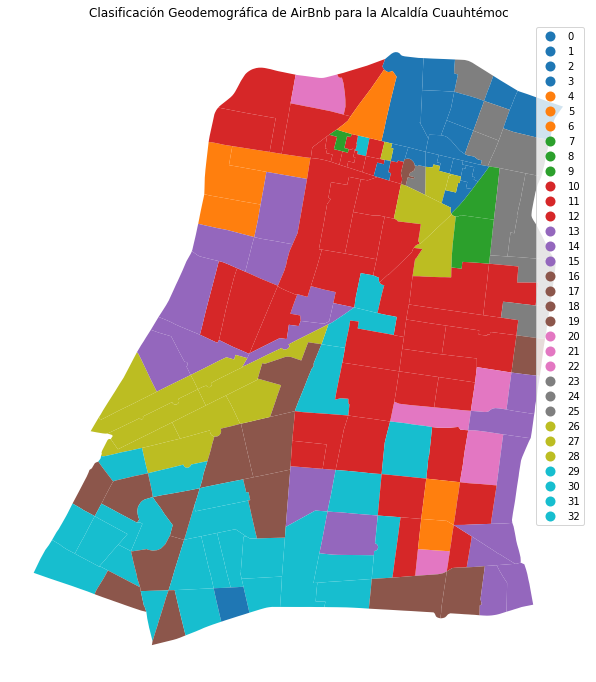

In [22]:
# Crear la figura y sus ejes
fig, ejes = plt.subplots(1, figsize=(12, 12))

# Generar un Mapa de Coropletas Categórico
airbnb.plot(column='azpcls', categorical=True, legend=True, edgecolor='', ax=ejes)

# Remover los ejes del mapa
ejes.set_axis_off()

# Asignar un título
plt.title('Clasificación Geodemográfica de AirBnb para la Alcaldía Cuauhtémoc')

# Mostrar el resultado
plt.show()

Inclusive es posible realizar el mismo tipo de análisis estadístico realizado anteriormente, de modo que puedan entenderse con mayor detalle las categorías generadas. Por ejemplo, para conocer el número de observaciones contenidas en cada categoría:

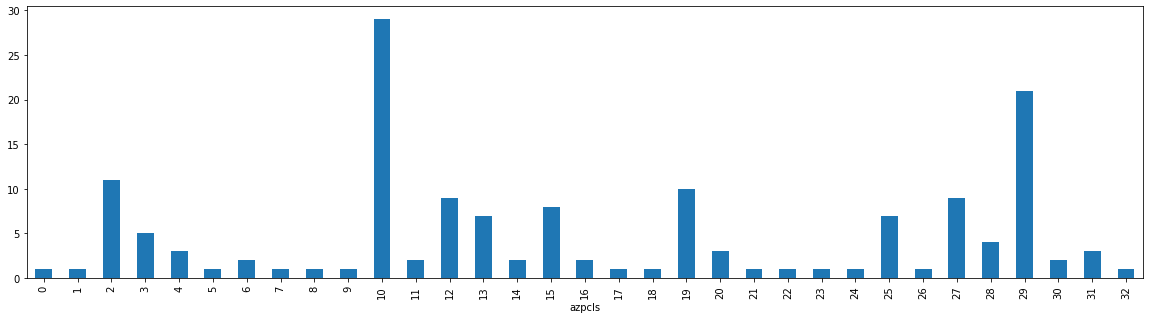

In [23]:
azp_cuentas = airbnb.groupby('azpcls').size()
_ = azp_cuentas.plot.bar(figsize = (20,5))

Asimismo, puede obtenerse un resumen estadístico de lo observado en cada una de las categorías:

In [24]:
azp_promedios = airbnb.groupby('azpcls')[calificaciones].mean()
azp_promedios.T

azpcls,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
calif,92.96080,85.4,97.454545,89.952680,97.162400,82.0,90.00,79.0,96.2,83.2,...,87.5,89.75,98.392857,92.0,94.350633,93.037500,95.301500,90.666650,96.685733,96.50
expec,9.49020,9.9,10.000000,9.020000,9.852437,9.4,9.50,7.6,7.7,8.2,...,9.5,10.00,9.857143,7.8,9.718612,9.129167,9.756096,9.333335,9.860220,10.00
limp,9.21569,9.1,9.954545,8.920000,9.832387,8.6,10.00,9.4,9.7,9.8,...,9.5,9.25,9.750000,8.6,9.541320,9.270835,9.563159,9.083335,9.740660,10.00
checkin,9.60784,8.5,9.954545,9.326666,9.859697,9.1,9.75,8.7,9.1,9.8,...,9.5,10.00,10.000000,7.8,9.792458,9.754167,9.819334,9.666665,9.917530,10.00
com,9.60784,10.0,10.000000,9.426668,9.913870,9.5,10.00,9.5,8.7,10.0,...,10.0,10.00,9.928571,7.8,9.738601,9.512500,9.827424,9.750000,9.903883,10.00
ubi,9.68627,8.3,9.454545,8.986668,9.586347,10.0,9.25,9.8,9.4,7.4,...,9.5,10.00,9.500000,10.0,9.909460,9.458333,9.835968,9.166665,9.788067,10.00
precio,9.43137,9.7,9.818182,8.646668,9.748583,7.6,10.00,8.0,8.7,9.4,...,9.5,9.50,9.857143,10.0,9.527439,9.254167,9.586201,9.333335,9.839143,9.75


___
### Mejorando la Visualización - `.dissolve()` en `GeoPandas`
El mapa anterior permite tener una visualización relativamente clara de los límites de las regiones generados por el Algoritmo *AZP*; sin embargo, ésta aún se basa en el coloreado de las áreas (AGEB's) más pequeñas que le componen. Como tal, para obtener propiamente las nuevas regiones, es necesario "fundir" todas las AGEB's que pertenecen a una misma categoría en un sólo polígono.

Lo anterior, dentro de los Sistemas de Información Geográfica, es una operación vectorial conocida como *Disolver* (*Dissolve*); se trata de una operación ampliamente difundida en todos los SIG, y también puede ejecutarse de forma muy sencilla en `GeoPandas` a través de la función [`.dissolve()`](http://geopandas.org/aggregation_with_dissolve.html):

In [25]:
# Almacenar las columnas del 'GeoDataFrame' que son de interés para '.dissolve()'
tmp = airbnb[['azpcls','geometry']]

# Ejecutar la función
colonias_airbnb = tmp.dissolve(by = 'azpcls')

En la celda anterior, se almacena dentro de una variable temporal (`tmp`) las columnas que son de interés para la función `.dissolve()`; en este caso, `azpcls`, debido a que las categorías contenidas en ésta serán las que determinarán qué polígonos se fundirán entre sí, y `geometry`, al contener la geometría de cada polígono. Posteriormente, se ejecuta la función a esta variable, indicando a través del argumento `by` cuál es la columna que regirá la operación.

Para visualizar el resultado, simplemente puede recurrirse a la función `.plot()`, dado que en la celda anterior se generó un nuevo `GeoDataFrame`:

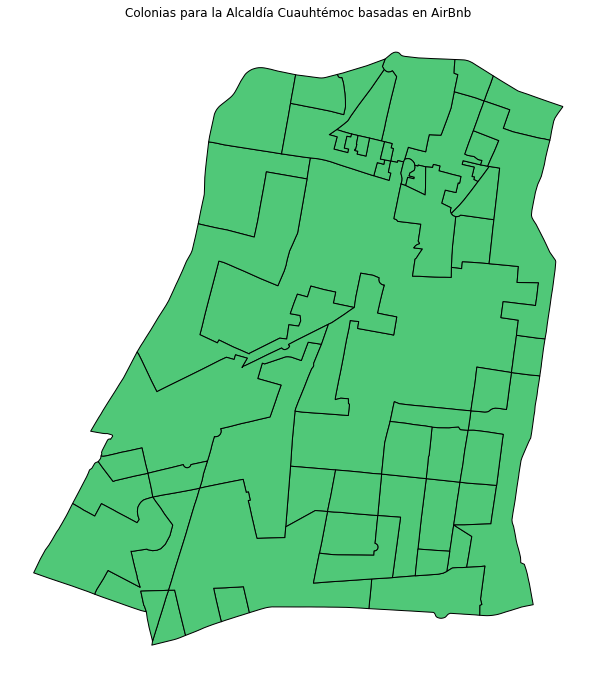

In [26]:
# Crear la figura y sus ejes
fig, ejes = plt.subplots(1, figsize=(12, 12))

# Graficar las nuevas colonias generadas
colonias_airbnb.plot(figsize = (10,10), edgecolor = 'black', facecolor = '#50C878', ax = ejes)

# Remover los ejes del mapa
ejes.set_axis_off()

# Asignar un título
plt.title('Colonias para la Alcaldía Cuauhtémoc basadas en AirBnb')

# Mostrar el resultado
plt.show()

___
### Comparación con Colonias Administrativas
En la realidad, la Alcaldía Cuauhtémoc ya se encuentra dividida en Colonias, cuyos límites estan basados en criterios administrativos y sociales. Como tal, resulta interesante comparar las similitudes y diferencias entre lo obtenido por el Algoritmo *AZP* y lo que se tiene en la realidad.

En la carpeta de trabajo se encuentra un `ShapeFile` que contiene estas colonias:

In [27]:
colonias_reales = gpd.read_file('data/colonias_cuauh.shp')  # Importar el archivo .shp
colonias_reales = colonias_reales.set_index('id')           # Determinar la variable 'id' como índice
colonias_reales.head()                                      # Observar la tabla

,nombre,geometry
id,,
1,TRANSITO,"POLYGON ((485831.0848741434 2146564.468719868,..."
2,TABACALERA,"POLYGON ((483661.5641039339 2149496.328670184,..."
3,ALGARIN,"POLYGON ((484813.6570845546 2145890.43225155, ..."
4,SANTA MARÍA LA RIBERA,"POLYGON ((483914.4153672198 2150223.807389105,..."
5,ATLAMPA,"POLYGON ((484371.2856019392 2151423.85187102, ..."


Y, de igual forma a como se hizo con las Colonias basadas en AirBnb, puede obtenerse un mapa:

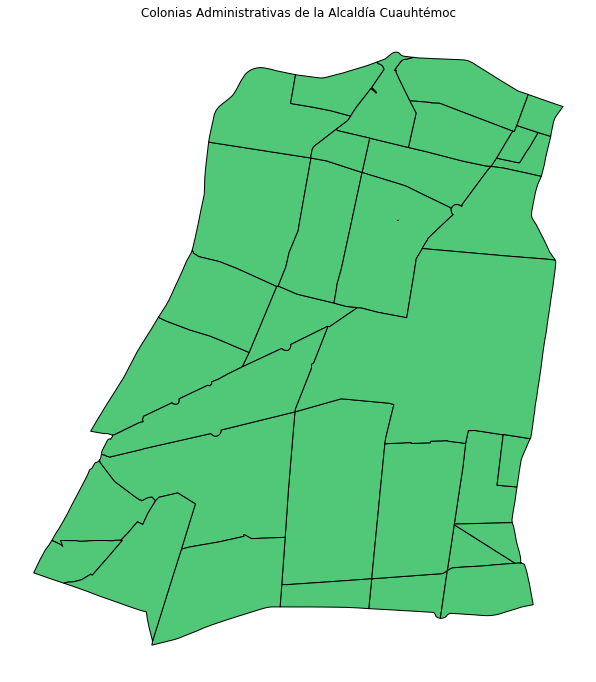

In [28]:
# Crear la figura y sus ejes
fig, ejes = plt.subplots(1, figsize=(12, 12))

# Graficar las colonias originales
colonias_reales.plot(figsize = (10,10), edgecolor = 'black', facecolor = '#50C878', ax = ejes)

# Remover los ejes del mapa
ejes.set_axis_off()

# Asignar un título
plt.title('Colonias Administrativas de la Alcaldía Cuauhtémoc')

# Mostrar el resultado
plt.show()

Resultaría de mayor utilidad si ambos mapas se generaran dentro de la misma figura, uno al lado del otro. Para conseguir esto, puede emplearse una aproximación muy similar a la manejada durante el mapeo inicial de las calificaciones de AirBnb, en la que se genera una cuadrícula de determinadas filas y columnas:

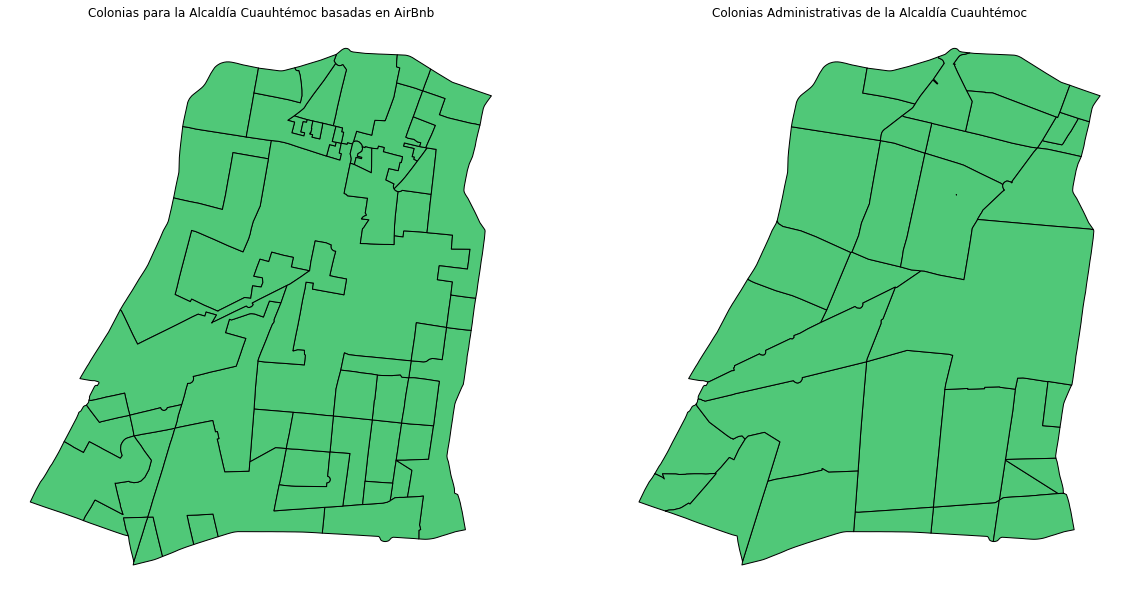

In [29]:
# Crear la figura y sus ejes
fig, ejes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 20))

# Aislar los ejes (cuadros) en sus propias variables
eje1 = ejes[0]
eje2 = ejes[1]

# Para el primer eje (cuadro)
# Graficar las nuevas colonias generadas
colonias_airbnb.plot(figsize = (10,10), edgecolor = 'black', facecolor = '#50C878', ax = eje1)
# Remover los ejes del mapa
eje1.set_axis_off()
# Asignar un título
eje1.set_title('Colonias para la Alcaldía Cuauhtémoc basadas en AirBnb')

# Para el segundo eje (cuadro)
# Graficar las colonias originales
colonias_reales.plot(figsize = (10,10), edgecolor = 'black', facecolor = '#50C878', ax = eje2)
# Remover los ejes del mapa
eje2.set_axis_off()
# Asignar un título
eje2.set_title('Colonias Administrativas de la Alcaldía Cuauhtémoc')

plt.show()

Observando el resultado, pueden destacarse algunas diferencias y similitudes entre los dos mapas. La más clara es que, mientras que los límites admnistrativos generan colonias de un tamaño balanceado y fácil de distinguir, los límites de las regiones generadas por *AZP* difieren enormemente entre sí, tanto en términos de tamaño como facilidad de visualización. Esto se debe propiamente a la naturaleza de los datos colocados en el algoritmo; basándose en las calificaciones de AirBnb, pueden observarse grandes colonias derivadas de AGEB's con características muy similares y, por ende, pertenecientes a la misma categoría, mientras que también se pueden distinguir enclaves con características lo suficientemente diferentes como para ser consideradas su propia región.

Los resultados obtenidos a través de los algoritmos disponibles en las distintas librerías de *Python* comúnmente son de gran utilidad y, por ende, resulta pertinente el poder almacenarlos como archivos aislados para continuar trabajando con ellos en un futuro, ya sea en algún Sistema de Información Geográfica, algún software de análisis estadístico u otro script de *Python*. Por fortuna, la librería `GeoPandas` ofrece una forma sencilla y veloz de almacenar cualquier tipo de `GeoDataFrame` generado, a través de la función `.to_file()`:

In [30]:
colonias_airbnb.to_file('data/colonias_airbnb.shp')

En la celda anterior, el `GeoDataFrame` con las colonias fue almacenado en formato `ShapeFile`; sin embargo, la librería [también ofrece la posibilidad](http://geopandas.org/io.html) de almacenar archivos en formato `GeoJSON` o `GeoPackage`; también es importante tomar en cuenta que el archivo exportado tendrá el mismo Sistema de Coordenadas de Referencia (CRS) que el `GeoDataFrame` original.
___
## Ejercicio Final
Reproduce la práctica, esta vez utilizando el `ShapeFile` dentro de la carpeta de datos bajo el nombre de `agebs_educacion.shp`; éste también contiene todas las AGEB's de la Alcaldía Cuauhtémoc, pero esta vez con datos del Nivel de Escolaridad de los habitantes de cada AGEB. Las variables que contiene son:
* `pob_analf` - Número de habitantes en el AGEB con analfabetismo (No saben leer ni escribir)
* `pob_sinedu` - Habitantes sin escolaridad alguna.
* `pob_basica` - Habitantes que cursaron Primaria y/o Secundaria, pero no la finalizaron
* `pob_secun` - Habitantes que finalizaron, como máximo, hasta el Nivel Básico (Secundaria)
* `pob_bach` - Habitantes que finalizaron, como máximo, hasta el Nivel Medio-Superior (Bachillerato-Preparatoria)
* `pob_sup` - Habitantes que poseen algún grado de Nivel Superior, sea Licenciatura, Maestría o Doctorado.

Para reproducir el ejercicio, es necesario:
* Importar los datos (`agebs_educacion.shp`)
* Crear una Segmentación Demográfica de la población utilizando el Método *K-Means*, así como todas las variables antes mencionadas. Esto implica:
  * Ejecutar el Método *K-Means*.
  * Obtener las etiquetas de clase a las que pertenece cada AGEB.
  * Visualizar las clases en un mapa.
  * Comparar el mapa obtenido con la distribución de las variables a través de, por ejemplo, Mapas de Coropletas.
* Crear una Regionalización con las mismas variables, produciendo nuevamente 33 regiones. Esto implica:
  * Generar la Matriz de Pesos Espaciales para las AGEB's.
  * Ejecutar el Algoritmo de Regionalización *AZP* (o algún otro de tu preferencia)
  * Extrar las etiquetas de región a las que pertenece cada AGEB, y visualizar en un mapa.
  * Comparar el resultado con las Colonias Administrativas de la Alcaldía Cuauhtémoc.